In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

import rasterio
from rasterio import plot

from osgeo import ogr, osr, gdal

%matplotlib inline
import earthpy as et
import earthpy.plot as ep
import copy
import pandas as pd
import xarray as xr

path_to_temp_max_folder = "/home/chris/Desktop/data_huglin_index_project/cmip5dc_global_5min_rcp2_6_2030s_asc/bcc_csm1_1_m_rcp2_6_2030s_tmax_5min_r1i1p1_no_tile_asc/"
path_to_temp_mean_folder = "/home/chris/Desktop/data_huglin_index_project/cmip5dc_global_5min_rcp2_6_2030s_asc/bcc_csm1_1_m_rcp2_6_2030s_tmean_5min_r1i1p1_no_tile_asc/"

no_data_value = -9999

In [2]:
class Huglin_Index():
    def __init__(self, no_data_value):
#         self.hemisphere = hemisphere
        self.no_data_value = no_data_value
        self.north_temp_mean_list = []
        self.north_temp_max_list = []
        self.south_temp_mean_list = []
        self.south_temp_max_list = []
        
        
    def get_data(self,path_to_temp_mean_folder,path_to_temp_max_folder):
        
        for i in range(4,10):
            #Getting the data without the header lines and as float type
            #they are stored as int and multiplied by 10 to preserve the first decimal 
            north_t_mean_array = (np.loadtxt(path_to_temp_mean_folder + "tmean_" + str(i) + ".asc", skiprows=6)).astype('float64')
            #Data values divided by 10 to get their real value, no data values are ignored
            north_t_mean_array[north_t_mean_array != self.no_data_value] = north_t_mean_array[north_t_mean_array != self.no_data_value]/10

            self.north_temp_mean_list.append(north_t_mean_array)

            north_t_max_array = (np.loadtxt(path_to_temp_max_folder + "tmax_" + str(i) + ".asc", skiprows=6)).astype('float64')
            north_t_max_array[north_t_max_array != self.no_data_value] = north_t_max_array[north_t_max_array != self.no_data_value]/10

            self.north_temp_max_list.append(north_t_max_array)

        for i in range(1,4):
            south_t_mean_array = (np.loadtxt(path_to_temp_mean_folder + "tmean_" + str(i) + ".asc", skiprows=6)).astype('float64')
            south_t_mean_array[south_t_mean_array != self.no_data_value] = south_t_mean_array[south_t_mean_array != self.no_data_value]/10

            self.south_temp_mean_list.append(south_t_mean_array)

            south_t_max_array = (np.loadtxt(path_to_temp_max_folder + "tmax_" + str(i) + ".asc", skiprows=6)).astype('float64')
            south_t_max_array[south_t_max_array != self.no_data_value] = south_t_max_array[south_t_max_array != self.no_data_value]/10

            self.south_temp_max_list.append(south_t_max_array) 

        for i in range(10,13):
            south_t_mean_array = (np.loadtxt(path_to_temp_mean_folder + "tmean_" + str(i) + ".asc", skiprows=6)).astype('float64')
            south_t_mean_array[south_t_mean_array != self.no_data_value] = south_t_mean_array[south_t_mean_array != self.no_data_value]/10

            self.south_temp_mean_list.append(south_t_mean_array)

            south_t_max_array = (np.loadtxt(path_to_temp_max_folder + "tmax_" + str(i) + ".asc", skiprows=6)).astype('float64')
            south_t_max_array[south_t_max_array != self.no_data_value] = south_t_max_array[south_t_max_array != self.no_data_value]/10

            self.south_temp_max_list.append(south_t_max_array)
        return
                
    def calculate_index(self):
        self.north_huglin_index = np.zeros(self.north_temp_mean_list[0].shape, dtype=float)
        self.south_huglin_index = np.zeros(self.south_temp_mean_list[0].shape, dtype=float)
        month = 4
        for i in range(len(self.north_temp_mean_list)):
            if month==4 or month==6 or month==9:
                north_huglin_index_var = 30*(self.north_temp_mean_list[i] + self.north_temp_max_list[i] - 20)/2
            else:
                north_huglin_index_var = 31*(self.north_temp_mean_list[i] + self.north_temp_max_list[i] - 20)/2

            self.north_huglin_index = self.north_huglin_index  + north_huglin_index_var
            month += 1

        month = 1
        for i in range(len(self.south_temp_mean_list)//2):
            if month==2:
                south_huglin_index_var = 28*(self.south_temp_mean_list[i] + self.south_temp_max_list[i] - 20)/2
            else:
                south_huglin_index_var = 31*(self.south_temp_mean_list[i] + self.south_temp_max_list[i] - 20)/2

            self.south_huglin_index = self.south_huglin_index  + south_huglin_index_var
            month += 1

        month = 10
        for i in range(len(self.south_temp_mean_list)//2):
            if month==11:
                south_huglin_index_var = 30*(self.south_temp_mean_list[i] + self.south_temp_max_list[i] - 20)/2
            else:
                south_huglin_index_var = 31*(self.south_temp_mean_list[i] + self.south_temp_max_list[i] - 20)/2

            self.south_huglin_index = self.south_huglin_index  + south_huglin_index_var
            month += 1

        
        
        x,y = self.south_huglin_index.shape
        self.lat = np.linspace(180, -180, x)
        self.lon = np.linspace(90, -90, y)
        
        
        self.north_huglin_dataset = xr.DataArray(data=self.north_huglin_index, dims=["lat", "lon"], coords=[self.lat,self.lon])
        self.south_huglin_dataset = xr.DataArray(data=self.south_huglin_index, dims=["lat", "lon"], coords=[self.lat,self.lon])
        
        north_lat_array_indexes= []
        south_lat_array_indexes= []
        

        lat0 = 40
        for i in range(0,11,2):
            tmp = float(self.north_huglin_dataset.sel(lat=lat0 + i,lon=-90,method='nearest').lat.data )
            north_lat_array_indexes.append(int(np.where(self.lat==tmp)[0]))

        lat0 = -40
        for i in range(0,-11,-2):
            tmp = float(self.south_huglin_dataset.sel(lat=lat0 + i,lon=-90,method='nearest').lat.data )
            south_lat_array_indexes.append(int(np.where(self.lat==tmp)[0]))

        
        
        k=[1.02,1.03,1.04,1.05,1.06]
        
        for i in range(len(north_lat_array_indexes)-1):
            for j in range(north_lat_array_indexes[i+1] - north_lat_array_indexes[i]):
                self.north_huglin_dataset[north_lat_array_indexes[i] + j] = self.north_huglin_dataset[north_lat_array_indexes[i] + j] * k[i]
                #pointer_to_row_latitude = self.huglin_dataset[lat_array_indexes[i] + j]
                #pointer_to_row_latitude[self.huglin_dataset[lat_array_indexes[i] + j] < no_data_value] = no_data_value
        
        
        self.north_huglin_max = np.amax(self.north_huglin_dataset.data)
        self.north_huglin_dataset.data[self.north_huglin_dataset < no_data_value] = no_data_value

        self.north_huglin_min = np.amin(self.north_huglin_dataset.data[self.north_huglin_dataset != np.amin(self.north_huglin_dataset)])

        for i in range(len(south_lat_array_indexes)-1):
            for j in range(south_lat_array_indexes[i+1] - south_lat_array_indexes[i]):
                self.south_huglin_dataset[south_lat_array_indexes[i] + j] = self.south_huglin_dataset[south_lat_array_indexes[i] + j] * k[i]
                #pointer_to_row_latitude = self.huglin_dataset[lat_array_indexes[i] + j]
                #pointer_to_row_latitude[self.huglin_dataset[lat_array_indexes[i] + j] < no_data_value] = no_data_value
        
        
        self.south_huglin_max = np.amax(self.south_huglin_dataset.data)
        self.south_huglin_dataset.data[self.south_huglin_dataset < no_data_value] = no_data_value

        self.south_huglin_min = np.amin(self.south_huglin_dataset.data[self.south_huglin_dataset != np.amin(self.south_huglin_dataset)])

        
        
        print(len(self.lat))
        print(len(self.lat)//2)
        print(len(self.lon))
        print(len(self.lon)//2)
        self.south_huglin_dataset[0:len(self.lat)//2-1][0:len(self.lon)//2-1] = self.north_huglin_dataset[0:len(self.lat)//2 - 1][0:len(self.lon)//2 - 1]
        
        
 
        return self.south_huglin_dataset
                
                
                
    def show_map(self):
        print("Huglin Index of combined Hemispheres")
        ep.plot_bands(self.south_huglin_dataset,cmap='PiYG',scale=False, vmin=self.south_huglin_min,vmax=self.south_huglin_max)
        
        return
    
    def return_huglin_index_from_lat_lon(self, lat, lon):
        return self.huglin_dataset.sel(lat=lat,lon=lon,method='nearest')
    
    
    def CreateGeoTiff(self, outRaster):
        data = []
        data.append(self.south_huglin_index)
#         data.extend(self.temp_mean_list)
#         data.extend(self.temp_max_list)
        data = np.array(data)
        
        driver = gdal.GetDriverByName('GTiff')
        no_bands, width, height = data.shape
        print(no_bands, width,height)
        DataSet = driver.Create(outRaster, height, width, no_bands, gdal.GDT_Float32)
        
        geo_info = self.array_to_raster()
        
        #DataSet.SetProjection ("EPSG:4326") #EPSG:4326
        DataSet.SetGeoTransform(geo_info[0])
        DataSet.SetProjection(geo_info[1])

        
        for i, image in enumerate(data, 1):
            print(i)
            DataSet.GetRasterBand(i).WriteArray(image)
        DataSet = None
        
        return
    
    def array_to_raster(self):
        
        old_raster_used_for_projection = gdal.Open("./geotransform_tiff.tif")
        
        width = old_raster_used_for_projection.RasterYSize
        height = old_raster_used_for_projection.RasterXSize
        gt = old_raster_used_for_projection.GetGeoTransform()
        wkt_projection = old_raster_used_for_projection.GetProjectionRef()


        return [gt,wkt_projection]

       

In [3]:
#Initialize object
north_hem_huglin = Huglin_Index(no_data_value)
#south_hem_huglin = Huglin_Index("S",no_data_value)

In [4]:
#Get data from tiff files
north_hem_huglin.get_data(path_to_temp_mean_folder,path_to_temp_max_folder)
#south_hem_huglin.get_data(path_to_temp_mean_folder,path_to_temp_max_folder)

In [5]:
#Calculate the Huglin Index
north_hem_huglin_index_object = north_hem_huglin.calculate_index()
#south_hem_huglin_index_object = south_hem_huglin.calculate_index()

# north_hem_huglin_index = north_hem_huglin_index_object.data
# #south_hem_huglin_index = south_hem_huglin_index_object.data

1800
900
4320
2160


In [9]:
# print(north_hem_huglin_index.shape)
# north_huglin_max_value = np.amax(north_hem_huglin_index[north_hem_huglin_index != np.amax(north_hem_huglin_index)])

# north_huglin_min_value = np.amin(north_hem_huglin_index[north_hem_huglin_index != np.amin(north_hem_huglin_index)])
# print(north_huglin_min_value)
# print(north_huglin_max_value)

(1800, 4320)
-4448.85
5867.0


Huglin Index of combined Hemispheres


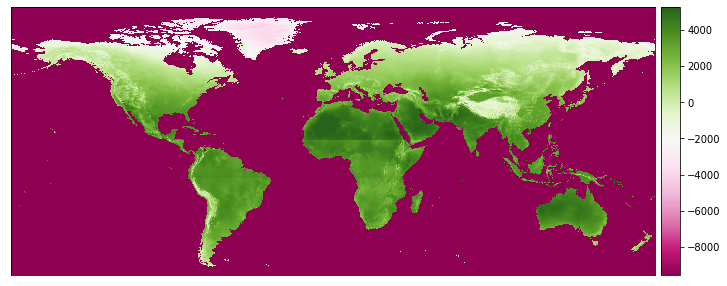

In [10]:
#Plot the map
north_hem_huglin.show_map()
#north_hem_huglin.return_huglin_index_from_lat_lon(13,-40)

In [27]:
#Save the new tiff file
north_hem_huglin.CreateGeoTiff("./new_Huglin_Index_Combined_test.tiff")

1 1800 4320
1
